### Import Libraries and Data

In [188]:
import zipfile
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from datetime import datetime
import pytz
from tensorflow.keras.callbacks import LearningRateScheduler,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,Nadam
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
import random
from tqdm import tqdm
import shutil
import io
from nltk.translate.gleu_score import sentence_gleu
import pickle

In [189]:
final_df = pd.read_csv('data\\final_df_preprocessed.csv')

In [190]:
final_df.shape

(22704, 6)

In [162]:
final_df = final_df[final_df['incorrect_word_count'] <= 12]
final_df.shape

(4971, 6)

In [191]:
final_df = final_df[['correct','incorrect']]

In [192]:
final_df[final_df.isna().any(axis=1)]

,correct,incorrect


###  Train Test Split

In [102]:
train = final_df

In [59]:
validation = final_df

In [73]:
test = final_df

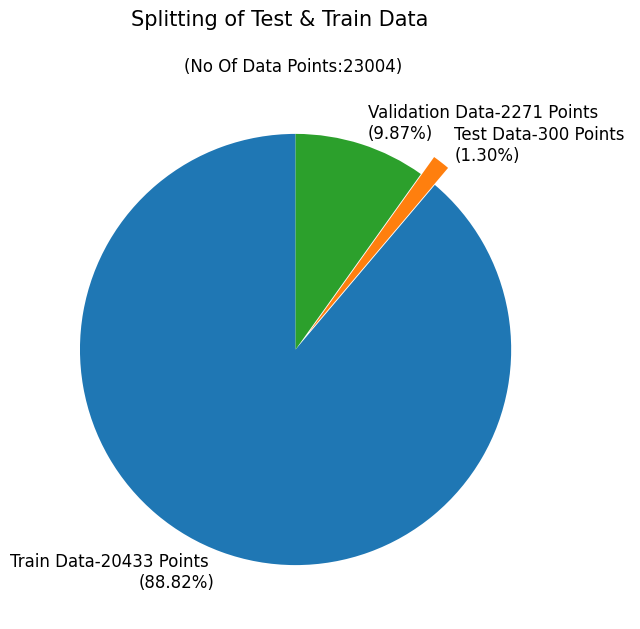

In [193]:
# train,test = train_test_split(final_df, test_size=0.1,random_state=15)
# train,validation = train_test_split(train, test_size=0.1)
train,validation = train_test_split(final_df, test_size=0.1)
fig,ax = plt.subplots(figsize =(10, 7))
labels_split = ['Train', 'Test','Validation'] 
sizes_split = [len(train),len(test),len(validation)]
pcts_split = [f'{l} Data-{s} Points \n({s*100/sum(sizes_split):.2f}%)' for s,l in zip(sizes_split, labels_split)] 
ax.pie(sizes_split, labels = pcts_split, startangle = 90, 
       explode=(0,0.1,0),textprops = {"fontsize":12} )

plt.suptitle(f'Splitting of Test & Train Data ', fontsize = 15)
plt.title(f'(No Of Data Points:{sum(sizes_split)}) ', fontsize = 12)
plt.show()

In [194]:
train['dec_correct_inp'] = '<start> ' + train['correct'].astype(str)
train['dec_correct_out'] = train['correct'].astype(str) + ' <end>'

validation['dec_correct_inp'] = '<start> ' + validation['correct'].astype(str)
validation['dec_correct_out'] = validation['correct'].astype(str) + ' <end>'

test['dec_correct_inp'] = '<start> ' + test['correct'].astype(str)
test['dec_correct_out'] = test['correct'].astype(str) + ' <end>'

In [195]:
train.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
14286,"First of all , could you provide me with infor...","First of all , could you provide me informatio...","<start> First of all , could you provide me wi...","First of all , could you provide me with infor..."
20540,It also has another negative effect you have l...,"It also has another negative effect , you have...",<start> It also has another negative effect yo...,It also has another negative effect you have l...
16915,"But to begin with , for a long time Anna was ...",But to begin with Anna for a long time was no...,"<start> But to begin with , for a long time An...","But to begin with , for a long time Anna was ..."
15276,"To avoid accidents , the government and airlin...","To avoid accidents , government and airline co...","<start> To avoid accidents , the government an...","To avoid accidents , the government and airlin..."
14572,"Shops could even give us a percent sale , whic...","Shops could give us even percent of sale , wha...",<start> Shops could even give us a percent sal...,"Shops could even give us a percent sale , whic..."


In [196]:
test.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
67,But my new friends from this group were very p...,But my new friends from this group were very p...,<start> But my new friends from this group wer...,But my new friends from this group were very p...
74,Every day I take public transport .,Every day I used to taking public transport .,<start> Every day I take public transport .,Every day I take public transport . <end>
108,The second problem could be from peers ' stres...,The second problem could be from peers ' stres...,<start> The second problem could be from peers...,The second problem could be from peers ' stres...
126,"Nowadays , young people are influenced by the ...",now days young people are influence towards th...,"<start> Nowadays , young people are influenced...","Nowadays , young people are influenced by the ..."
191,I attach a full CV and if you require more inf...,I attach a full CV and if you require more inf...,<start> I attach a full CV and if you require ...,I attach a full CV and if you require more inf...


In [197]:
validation.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
19457,"According to its supporters , there are many b...","According to supporters of it , there are many...","<start> According to its supporters , there ar...","According to its supporters , there are many b..."
14647,"On the other hand , we all get to benefit from...","On the other hand , we all get to benefit from...","<start> On the other hand , we all get to bene...","On the other hand , we all get to benefit from..."
15592,I am addicted to padel !,I am an addict to padel !,<start> I am addicted to padel !,I am addicted to padel ! <end>
14704,As if I can not imagine if I were a heroine of...,As if I can not imagine if I were a heroin of ...,<start> As if I can not imagine if I were a he...,As if I can not imagine if I were a heroine of...
17186,"By playing physical games , they will not only...",By playing physical games they will not only i...,"<start> By playing physical games , they will ...","By playing physical games , they will not only..."


In [198]:
train.to_csv('data/train.csv')

In [199]:
validation.to_csv('data/validation.csv')

In [200]:
test.to_csv('data/test.csv')

### Tokenizer

In [201]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)

In [202]:
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

In [203]:
vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)

Encoder words vocab size: 19707


In [204]:
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

Decoder words vocab size:: 16427


In [205]:
tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)

(3, None)

In [206]:
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

In [207]:
with open('data/tokenizer_enc_20211112.pkl', 'wb') as f:
  pickle.dump(tokenizer_enc, f)

with open('data/tokenizer_dec_20211112.pkl', 'wb') as f:
  pickle.dump(tokenizer_dec, f)

In [208]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

Encoder words vocab size: 19707
Decoder words vocab size:: 16427


### Text to Sequence

Mean Word Count:21.023050946997504


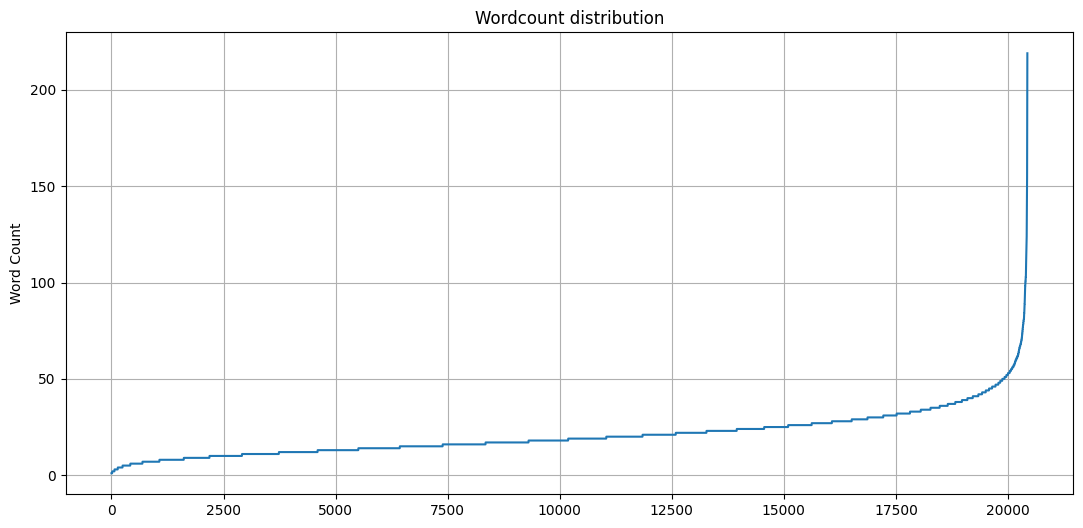

In [209]:
content=train['incorrect'].astype('str')
content_word_count=[len(content.iloc[i].split()) for i in range(len(content))]
mean_word_count=np.mean(content_word_count)
print(f'Mean Word Count:{mean_word_count}')
index=[i for i in range(0,len(content_word_count))]
fig, ax=plt.subplots(figsize=(13, 6))
plt.plot(index,sorted(content_word_count))
plt.grid()
plt.title("Wordcount distribution")
plt.ylabel("Word Count")
plt.show()

In [210]:
#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
test_enc_inp = pad_sequences(test_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

In [211]:
#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)
test_dec_inp = tokenizer_dec.texts_to_sequences(test['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_inp = pad_sequences(test_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

In [212]:
#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)
test_dec_out = tokenizer_dec.texts_to_sequences(test['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_out = pad_sequences(test_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

In [213]:
with open('data/train_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_enc_inp, f)

with open('data/val_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_enc_inp, f)

with open('data/test_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_enc_inp, f)

In [214]:
with open('data/train_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_inp, f)

with open('data/val_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_inp, f)

with open('data/test_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_inp, f)

In [215]:
with open('data/train_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_out, f)

with open('data/val_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_out, f)

with open('data/test_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_out, f)